# [개념 필사]

# CHAPTER 07 <군집화>

## 03. 평균 이동

> 평균이동: K-평균과 유사하지만, 데이터의 밀도가 가장 높은 곳으로 중심을 이동시키는 기법.

* 데이터 분포도를 기반으로 군집 중심점(확률밀도함수가 PEAK인점) 탐색
* 확률밀도함수 찾는 방법: KDE. 커널 함수를 통해 어떤 변수의 PDF를 추정하는 대표적 방법.

  -- 개별 관측 데이터에 커널 함수 적용해 모두 SUM ÷n

  -- 대표적인 커널 함수: 가우시안 함수

  -- h: 대역폭. KDE 형태를 뾰족하게(과적합) OR 부드럽게(과소적합) ; 적절한 h 계산 중요!!

* 대역폭의 크기에 따라서 군집화 수행 (군집개수 지정 X)
* 대역폭값에 따라 군집화에 큰 영향

```
MeanShift 사이킷런 클래스

bandwidth: KDE 대역폭 h

estimate_bandwidth(): 최적의 대역폭 계산 함수. 피처 데이터 세트 입력.

cluster_centers_ 속성: 군집 중심 좌표
```

* 장점: 유연한 군집화 / 이상치에 민감하지 않음 / 군집 개수 지정 불필요
* 단점: 수행 시간 오래 걸림 / bandwidth에 따른 영향력 차이가 너무 큼.
* 주로 컴퓨터 비전 영역에서 사용


## 04. GMM (Gaussian Mixture Model)

> GMM: 데이터가 여러 개의 가우시안 분포(정규 분포)를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 수행하는 군집화 방식.

* 확률 기반 군집화
* 전체 데이터를 구성하는 여러 개의 정규 분포 곡선 추출 -> 개별 데이터가 어떤 정규 분포에 속하는지 결정 ; **모수 추정**

  -- 개별 정규 분포의 평균, 분산
  
  -- 각 데이터가 어떤 분포에 해당될 확률

  -- EM 방식 사용

```
GaussianMixture 사이킷런 클래스

n_components: 가우시안 mixture 모델의 총 개수.
```

* K-평균: 원형의 범위에서 군집화 수행. 데이터가 원형의 범위일수록 성능 좋음. 타원(길쭉한 방향) 범위일수록 성능 감소.

* GMM: K-평균에 비해, 다양한 형태의 데이터 세트에 유연하게 잘 적용.  



# [코드 필사]

* 평균이동

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X,y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [2]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


In [3]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


In [4]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# 최적 대역폭으로 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]

    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray',
                alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', marker='$%d$'% label)

plt.show()

In [6]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


* GMM

In [7]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [9]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 칼럼으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target']=iris.target

# 매핑 확인
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


In [12]:
# k-평균 군집화 수행 결과 (비교용)

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


* gmm , k-평균 비교

In [13]:
# 군집 수행 시각화 함수
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

In [14]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개 군집세트, cluster_std = 0.5 만듦.
X, y  = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위해 변환함.
transformation = [[0.60834549, -0.63667341],[-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1','ftr2'])
clusterDF['target'] = y
# 생성된 데이터 세트를 target 별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target',iscenter=False)

<ipython-input-13-5b6e9addb6b2>:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\


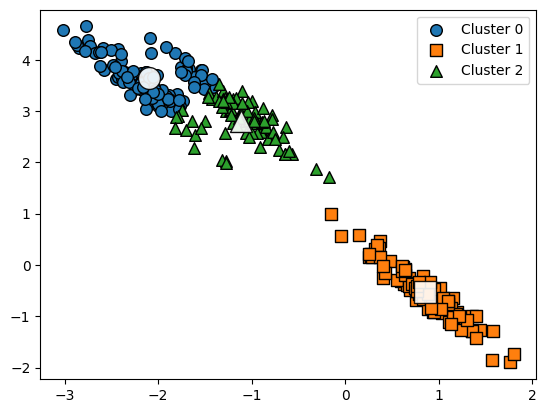

In [15]:
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

In [16]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

In [17]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64
